# ENGSCI762 Data Science Assignment

Develop a classifier for the California Housing dataset, which estimates the probability that the median house price of a specific district is larger or equal to USD500,000.

In [27]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

## TASK 1 Define the label

-  Execute notebook `2_get_California_housing_data.ipynb` and download the California Housing dataset.
-  Write a function, which converts the continuous `median_house_value` into a class label, such that the label TRUE or 1 indicates a high priced district.
-  Amend the function `split_feature_labels()` (see below) from `4_prepare_California_housing.ipynb` by an optional parameter, which switches the output of the target from regression to classification  


In [28]:
def convert_median_house_value(housing):
    housing["median_house_value"] = housing["median_house_value"] >= 500000
    return housing

def split_features_labels(filename = '../data/train_set.csv', 
                          target_col='median_house_value',
                          classify=True):
    df = pd.read_csv(filename, index_col=0)
    
    if classify:
        df = convert_median_house_value(df)
       
    X = df.drop(target_col, axis=1)
    y = df[target_col].copy()
    
    return X, y

housing, housing_labels = split_features_labels(classify=True)
housing_test, housing_test_labels = split_features_labels('../data/test_set.csv', classify=True)

housing.describe()

C:\Anaconda\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000
mean,-119.571981,35.634687,28.667696,2637.814801,538.206804,1426.546875,499.568314,3.867417
std,2.006763,2.138614,12.582749,2178.859507,420.659688,1141.436888,380.887558,1.903056
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1453.000000,NaN,786.000000,280.000000,2.560300
50%,-118.490000,34.250000,29.000000,2127.000000,NaN,1167.000000,410.000000,3.534800
75%,-118.007500,37.720000,37.000000,3150.000000,NaN,1728.250000,606.000000,4.739600
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


## TASK 2: Exploratory analysis

- If you randomly choose a feature vector from your training set: What is the probability that this feature vector describes a high priced district with `median_house_value`>= USD500,000.
- Develop a function `conddist`, which visualizes the conditional distribution of a specific features with respect to the class labels. (Tip: consider seaborn.distplot) 
- Visualize the spatial distribution of the high-priced districts only (ignoring the other districts).

In [29]:
housing_temp = pd.read_csv('../data/train_set.csv', index_col = 0)
housing_temp = convert_median_house_value(housing_temp)

sum(housing_temp["median_house_value"])/housing_temp['median_house_value'].count()

0.046875

4.7% chance the feature vector describes a high value district

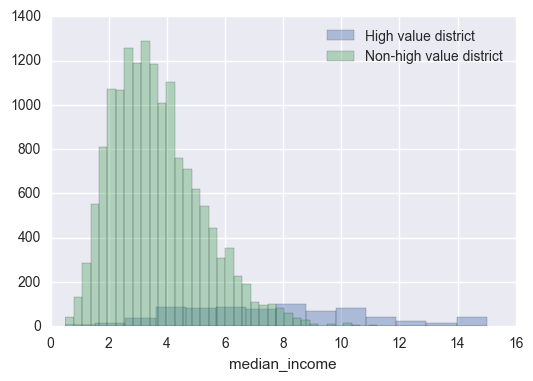

In [30]:
def conddist(data, feature):
    sns.distplot(data[feature][housing_labels], kde=False, label="High value district")
    sns.distplot(data[feature][-housing_labels], kde=False, label="Non-high value district")
    plt.legend()
    plt.show()

    
conddist(housing_temp, 'median_income')

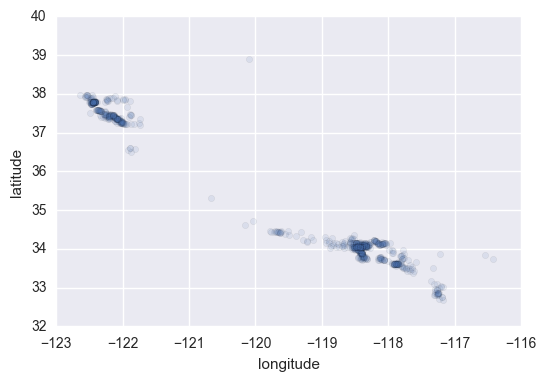

In [31]:
housing_copy = housing_temp.copy()
housing_copy.where(housing_copy['median_house_value'], inplace=True)
housing_copy.dropna(subset=['median_house_value'], inplace=True)
housing_copy.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

## TASK 3: Missing transformation

In notebook `3_explore_California_housing.ipynb` we had identified a useful transformation, which has not been implemented in `4_prepare_California_housing.ipynb`. 
* Amend the code of class `CombinedAttributesAdder` in order to include this transformation.
* Demonstrate that you're preparation pipeline has been successfully changed. 

### Temporarily remove categorical attribute

In [32]:
# Create DataFrame with numerical features
housing_num = housing.drop("ocean_proximity", axis=1)

### Define pipelines

In [33]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class Binarizer(BaseEstimator, TransformerMixin):
    "Work around until CategoricalEncoder is in stable branch"
    def __init__(self):
        self.binarizer = LabelBinarizer()
    def fit(self, X, y=None):
        return self.binarizer.fit(X)
    def transform(self, X, y=None):
        return self.binarizer.transform(X)
    
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.added_columns = ["rooms_per_household", "population_per_household", "log_population_per_household"]
        if self.add_bedrooms_per_room:
            self.added_columns += ["bedrooms_per_room"]
            
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        log_population_per_househould = np.log(population_per_household)
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, log_population_per_househould, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household, log_population_per_househould]
        
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# Monkey-patch function returning feature names
all_num_columns = num_attribs + num_pipeline.named_steps['attribs_adder'].added_columns
num_pipeline.get_feature_names = lambda: all_num_columns

# Modify class by inheritance
cat_pipeline_steps = [
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_encoder', Binarizer()),
    ]

class MyPipeline(Pipeline):
    def get_feature_names(self):
        return self.steps[1][1].binarizer.classes_
    
cat_pipeline = MyPipeline(cat_pipeline_steps)

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [34]:
X_train = pd.DataFrame(preparation_pipeline.fit_transform(housing),
                       columns=preparation_pipeline.get_feature_names(),
                       index = housing.index)
X_train.head()

,num_pipeline__longitude,num_pipeline__latitude,num_pipeline__housing_median_age,num_pipeline__total_rooms,num_pipeline__total_bedrooms,num_pipeline__population,num_pipeline__households,num_pipeline__median_income,num_pipeline__rooms_per_household,num_pipeline__population_per_household,num_pipeline__log_population_per_household,num_pipeline__bedrooms_per_room,cat_pipeline__<1H OCEAN,cat_pipeline__INLAND,cat_pipeline__ISLAND,cat_pipeline__NEAR BAY,cat_pipeline__NEAR OCEAN
1862,-2.281365,2.887619,-0.927305,0.292908,0.217002,1.856885,0.224303,-0.830593,0.060497,0.255269,2.775788,-0.346868,0.0,0.0,0.0,0.0,1.0
18832,-1.668419,2.836182,-0.450447,0.633004,0.608756,0.181753,0.313571,-0.793651,0.402002,-0.039779,-0.265156,-0.260680,0.0,1.0,0.0,0.0,0.0
2488,-0.387710,0.236288,-1.563116,0.015231,0.262388,0.050336,0.108780,-1.135007,-0.193990,-0.030870,-0.124698,0.450124,0.0,1.0,0.0,0.0,0.0
7637,0.638850,-0.848560,-0.609400,0.800987,0.869129,1.106054,1.085476,-0.225916,-0.246395,-0.013438,0.135438,-0.128123,1.0,0.0,0.0,0.0,0.0
6941,0.733532,-0.769067,0.185363,-0.767771,-0.764773,-0.725026,-0.770771,-0.602847,-0.291004,-0.016668,0.088602,0.176319,1.0,0.0,0.0,0.0,0.0


## TASK 4: Visualize new continuous features
* Use function `conddist` from Task 2 for visualizing the new continuous features.
* Discuss the diagrams

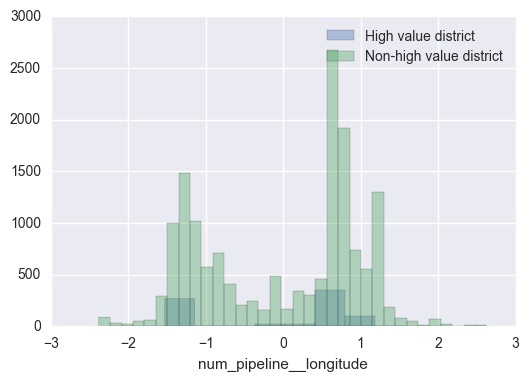

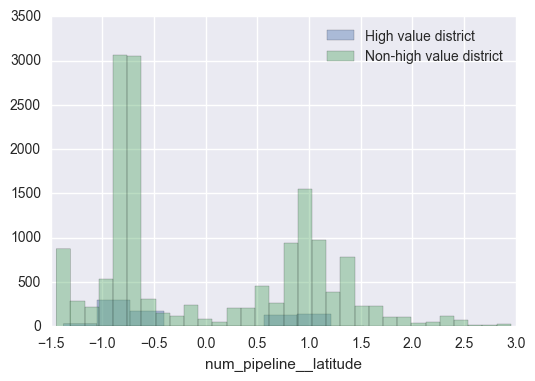

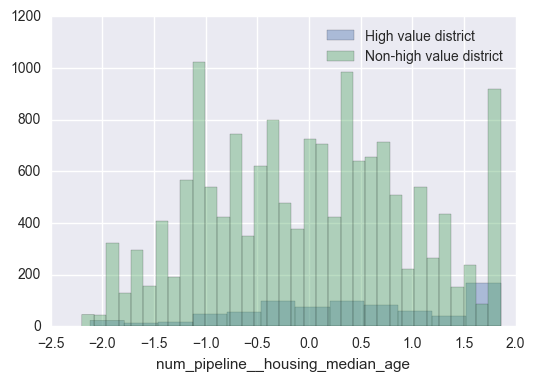

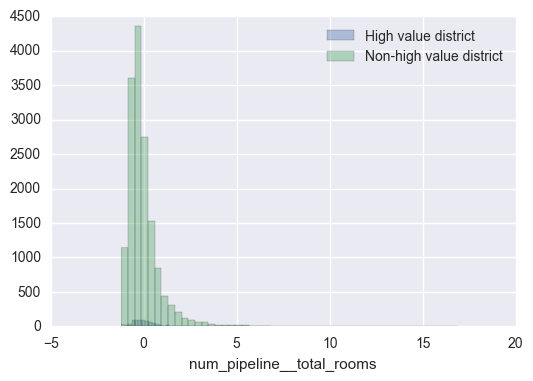

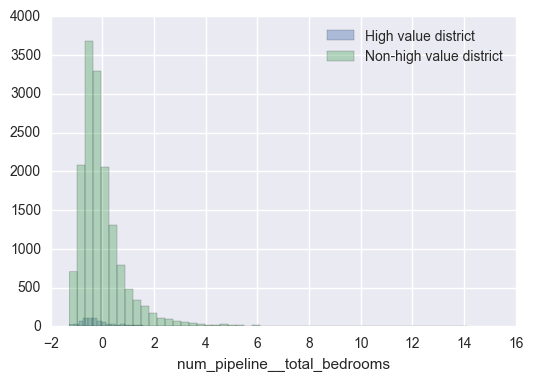

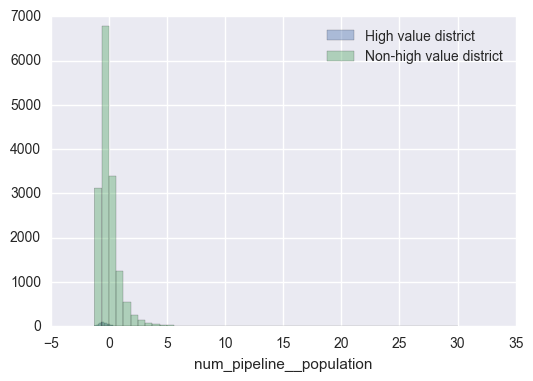

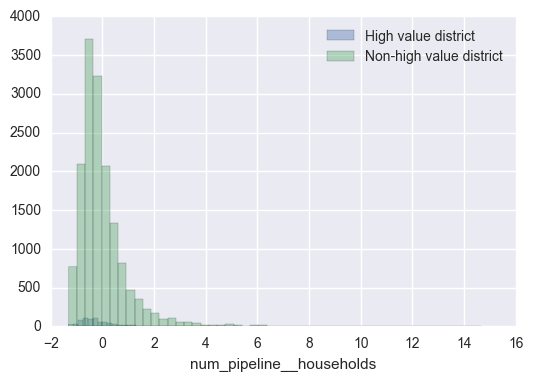

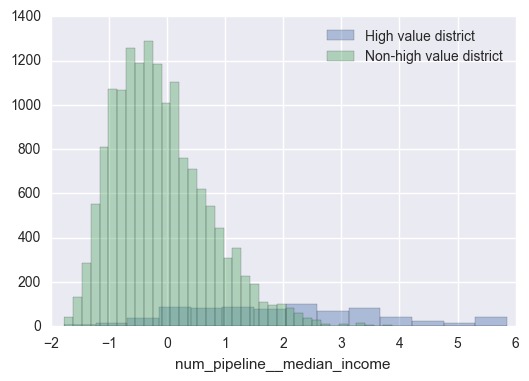

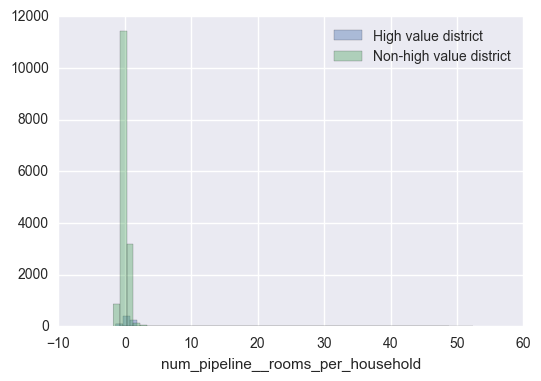

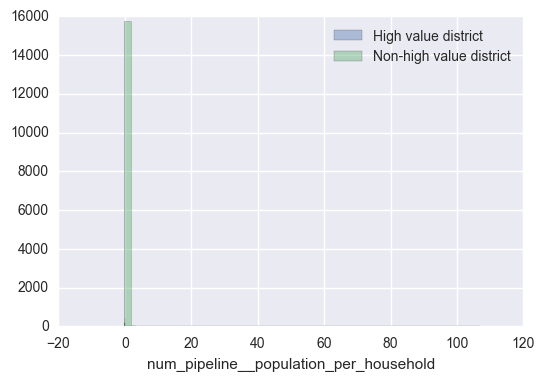

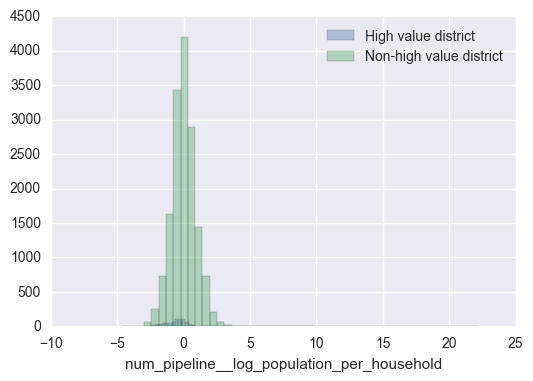

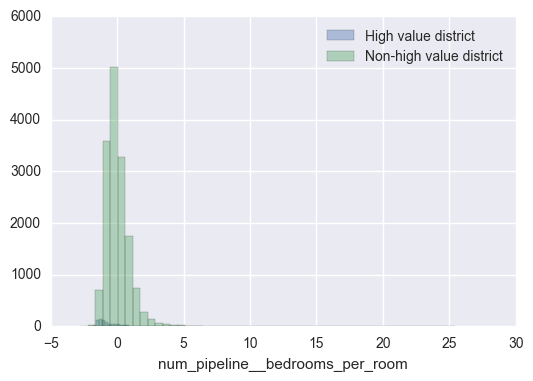

In [35]:
num_features = [x for x in X_train if x.startswith('num')]

for x in num_features:
    conddist(X_train, x)

Of all the features, median income seems the most useful for differentiating between the class labels.
Rooms per household also seems useful, as does bedrooms per room.

Other features do not seem to have any predictive power.


## TASK 5: Use clustering for the engineering of additional geo-spatial features

- Read the documentation of `sklearn.clustering.KMeans` and train a `KMeans`model with respect to `longitude` and `lattidue`.
- Visualize the predictions of KMeans.
- How do the predictions change for different values of parameter `n_clusters`? 

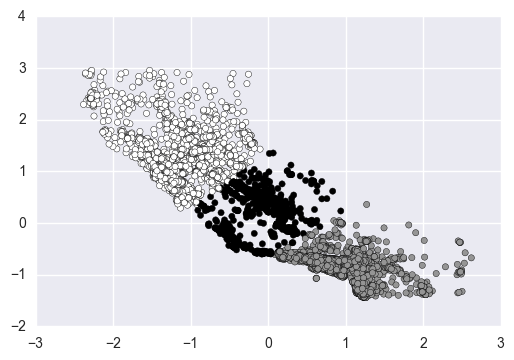

In [36]:
from sklearn.cluster import KMeans

n_clusters = 3

X_coord = np.c_[X_train['num_pipeline__longitude'], X_train['num_pipeline__latitude']]
y_pred = KMeans(n_clusters=n_clusters).fit_predict(X_coord)
plt.scatter(X_coord[:,0], X_coord[:,1], c=y_pred)

Increasing n_clusters increases the number of distinct groups the prediction can assign the district to.

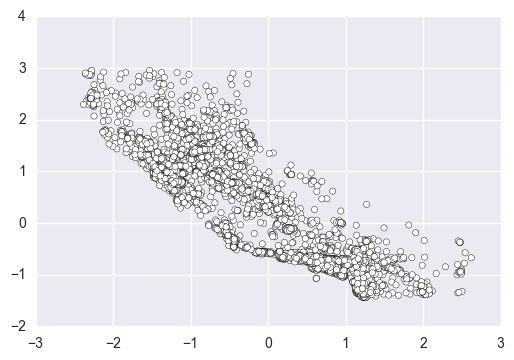

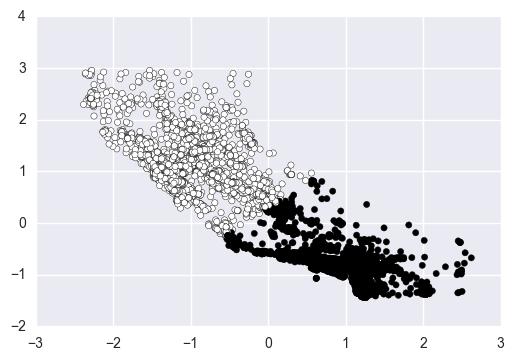

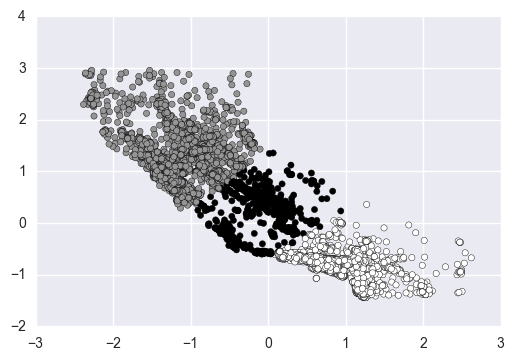

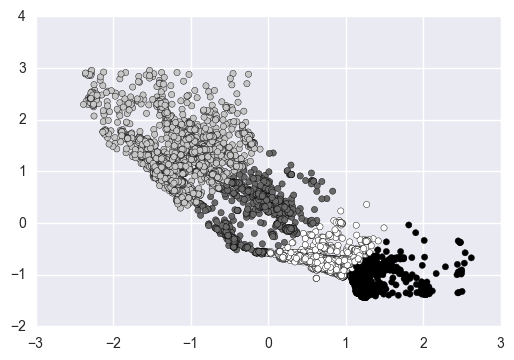

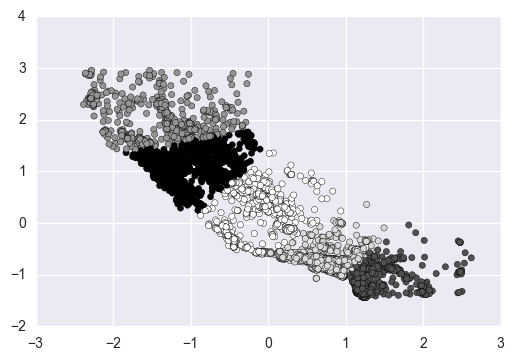

In [37]:
for i in range(5):
    X_coord = np.c_[X_train['num_pipeline__longitude'], X_train['num_pipeline__latitude']]
    y_pred = KMeans(n_clusters=i+1).fit_predict(X_coord)
    plt.scatter(X_coord[:,0], X_coord[:,1], c=y_pred)
    plt.show()

## TASK 6: Add the KMeans predictions to the preparation pipeline

* Develop an extended `preparation_pipeline`, which includes the geo-spatial information provided by `KMeans.fit_transform()`. 
* What is the interpretation of these features?

In [38]:
n_clusters = 8

In [39]:
# Modify class by inheritance
kmeans_pipeline_steps = [
        ('selector', DataFrameSelector(['longitude', 'latitude'])),
        ('clustering', KMeans(n_clusters = n_clusters)),
    ]

class KMyPipeline(Pipeline):
    def get_feature_names(self):
        return ['cluster_' + str(s) for s in range(n_clusters)]
    
kmeans_pipeline = KMyPipeline(kmeans_pipeline_steps)

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("geo_pipeline", kmeans_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

This adds new features with value equal to the distance from the cluster centres

In [40]:
X_train = pd.DataFrame(preparation_pipeline.fit_transform(housing),
                       columns=preparation_pipeline.get_feature_names(),
                       index = housing.index)
X_train.head()

,num_pipeline__longitude,num_pipeline__latitude,num_pipeline__housing_median_age,num_pipeline__total_rooms,num_pipeline__total_bedrooms,num_pipeline__population,num_pipeline__households,num_pipeline__median_income,num_pipeline__rooms_per_household,num_pipeline__population_per_household,...,geo_pipeline__cluster_3,geo_pipeline__cluster_4,geo_pipeline__cluster_5,geo_pipeline__cluster_6,geo_pipeline__cluster_7,cat_pipeline__<1H OCEAN,cat_pipeline__INLAND,cat_pipeline__ISLAND,cat_pipeline__NEAR BAY,cat_pipeline__NEAR OCEAN
1862,-2.281365,2.887619,-0.927305,0.292908,0.217002,1.856885,0.224303,-0.830593,0.060497,0.255269,...,4.307819,6.836953,11.358154,4.175098,8.312715,0.0,0.0,0.0,0.0,1.0
18832,-1.668419,2.836182,-0.450447,0.633004,0.608756,0.181753,0.313571,-0.793651,0.402002,-0.039779,...,3.835611,6.006383,10.527682,3.332074,7.609460,0.0,1.0,0.0,0.0,0.0
2488,-0.387710,0.236288,-1.563116,0.015231,0.262388,0.050336,0.108780,-1.135007,-0.193990,-0.030870,...,2.646560,0.867776,4.615460,2.830242,1.489549,0.0,1.0,0.0,0.0,0.0
7637,0.638850,-0.848560,-0.609400,0.800987,0.869129,1.106054,1.085476,-0.225916,-0.246395,-0.013438,...,5.740355,3.149763,1.568952,5.807493,1.668532,1.0,0.0,0.0,0.0,0.0
6941,0.733532,-0.769067,0.185363,-0.767771,-0.764773,-0.725026,-0.770771,-0.602847,-0.291004,-0.016668,...,5.758035,3.088572,1.507098,5.762181,1.730854,1.0,0.0,0.0,0.0,0.0


## TASK 7: Evaluate different classifiers and select two

* Evaluate the accuracy of `LogisticRegression`, `DecisionTreeClassifier`, `AdaBoostClassifier`, `GradientBoostingClassifier`, and `RandomForestClassifier` with 10-fold cross-validation. 

- Discuss the most important features for the two best performing classifiers. Are the geo-spatial features relevant?

- Select the best performing classifier for the next task.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

log_reg = LogisticRegression()
dec_cls = DecisionTreeClassifier()
adb_cls = AdaBoostClassifier()
grb_cls = GradientBoostingClassifier()
fst_cls = RandomForestClassifier()

In [42]:
from sklearn.model_selection import cross_val_score

y_train = housing_labels
cv_scores = lambda reg: cross_val_score(reg, X_train, np.ravel(y_train), scoring="f1", cv=10)

regressors = ['log_reg', 'dec_cls', 'adb_cls', 'grb_cls', 'fst_cls']

scores = dict([(var, cv_scores(globals()[var])) for var in regressors])
performance = pd.DataFrame(scores)
performance

,adb_cls,dec_cls,fst_cls,grb_cls,log_reg
0,0.636364,0.535948,0.640000,0.676259,0.640625
1,0.573643,0.540881,0.634921,0.651852,0.587302
2,0.656716,0.622754,0.630769,0.724638,0.661417
3,0.592593,0.609272,0.640625,0.647887,0.652174
4,0.612903,0.594937,0.666667,0.646154,0.600000
5,0.666667,0.638554,0.718750,0.731343,0.619048
6,0.595420,0.531469,0.586207,0.608000,0.573770
7,0.629921,0.602740,0.661290,0.731343,0.611570
8,0.532258,0.536913,0.609375,0.609375,0.472727
9,0.584615,0.571429,0.702290,0.671429,0.619048


In [ ]:
# Works on some versions of pandas and not others
# Gives grb_cls and fst_cls as two best classifiers, in that order
performance.aggregate(['mean', 'std'])

In [44]:
fst_cls.fit(X_train, np.ravel(y_train))
grb_cls.fit(X_train, np.ravel(y_train))

importance = pd.DataFrame(dict([(var, globals()[var].feature_importances_) 
                                for var in ['fst_cls', 'grb_cls']]),
                          index = X_train.columns)

importance.sort_values(by='grb_cls', ascending=False)

,fst_cls,grb_cls
num_pipeline__median_income,0.282800,0.252656
num_pipeline__rooms_per_household,0.101760,0.100366
num_pipeline__latitude,0.036374,0.088784
geo_pipeline__cluster_3,0.039241,0.061837
num_pipeline__population_per_household,0.039599,0.054880
geo_pipeline__cluster_7,0.039934,0.054784
geo_pipeline__cluster_6,0.036461,0.051089
geo_pipeline__cluster_1,0.045405,0.048580
num_pipeline__longitude,0.031684,0.042388
num_pipeline__log_population_per_household,0.040900,0.038931


Median income is the most important feature, which makes sense and is fairly intuitive.
Next, rooms per household seems to be a good indicator as to the median price - also intuitive as size of house would be the underlying factor here.
The geospatial features are relevant as some are > 0.05. Removing num_pipeline__latitude/longitude would likely increase the feature relevance of the clustering features, as they are describing the same thing.

Best performing: gradient boosting.

## TASK 8: Fine-tune the hyper-parameters of the best classifiers from Task 7

* Select the best performing classifier from TASK 7 and fine-tune its hyper-parameters.

In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=16),
    }

grb_cls = GradientBoostingClassifier()
rnd_search = RandomizedSearchCV(grb_cls, param_distributions=param_distribs,
                                n_iter=100, cv=10, scoring='f1',
                                n_jobs=4)
rnd_search.fit(X_train, np.ravel(y_train))
rnd_search.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=8, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=173,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [52]:
importance = pd.DataFrame({'importance': rnd_search.best_estimator_.feature_importances_},
                          index = X_train.columns)
importance.sort_values(ascending=False, by='importance')

,importance
num_pipeline__median_income,0.172029
num_pipeline__rooms_per_household,0.080829
num_pipeline__population_per_household,0.068080
geo_pipeline__cluster_7,0.063593
num_pipeline__log_population_per_household,0.056380
geo_pipeline__cluster_4,0.054730
geo_pipeline__cluster_3,0.051494
geo_pipeline__cluster_6,0.050725
geo_pipeline__cluster_1,0.050077
geo_pipeline__cluster_2,0.043782


## TASK 9: Measure the performance of your model
    
* Evaluate your best model on the test set. 
* What is its accuracy? 
* Compare the result to the accuracy you would get from guessing.

In [53]:
from sklearn.metrics import accuracy_score

final_model = rnd_search.best_estimator_

X_test = pd.DataFrame(preparation_pipeline.fit_transform(housing_test),
                       columns=preparation_pipeline.get_feature_names(),
                       index = housing_test.index)

y_pred = final_model.predict(X_test)
print(accuracy_score(housing_test_labels, y_pred))

0.8803294573643411


0.046875 of the data set describes a high priced district (from task 2). If we simply guess all feature sets describe non-high priced districts, we can attain 95.3% accuracy.

The fitted classifier has a 88.0% accuracy. This is worse than simply guessing. However, this will give more (ie non-zero) true positives for high-value district predictions, at the cost of more (ie non-zero) false positives for high-value district predictions.


